# Assignment 3: Predictive analysis - Part 1: Linear Regression
## Group 105
- Natasa Bolic (300241734)
- Brent Palmer (300193610)
## Imports

In [ ]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

## Introduction

## Dataset Description

**Url:** https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho <br>
**Name:** Vehicle Dataset <br>
**Author:** The author is not provided. However, the data is scraped from CarDekho, which is an online platform for selling and buying used cars in India. <br>
**Purpose:** The dataset consists of features of used cars. One purpose of the dataset is to allow users to practice linear regression to predict car prices, as described on Kaggle. However, it does not appear that the dataset has one original purpose, it can be used for many car-related applications. <br>
**Shape:** There are 4340 rows and 8 columns. (4340, 8)<br>
**Features:**
- `name` (categorical): The name of the car, including the car brand and the model name and variants.
- `year` (numerical): TODO
- `selling_price` (numerical): The price of the car.
- `km_driven` (numerical): The number of kilometres that the car has been driven.
- `fuel` (categorical): The fuel type of the car, which can be petrol, diesel, CNG, LPG or electric.
- `seller_type` (categorical): The type of the seller, which can be either an individual or a dealer.
- `transmission` (categorical): The car's gear transmission, which can be either automatic or manual.
- `owner` (categorical): The number of individuals that have previously owned the car.

Note: we have already used a dataset in the same domain (cars) in a previous assignment, but this is a different dataset with different features.

## Loading Data and Basic Exploration

In [64]:
# Read in the dataset from a public repository
url = "https://raw.githubusercontent.com/Natasa127/CSI4142-A3/refs/heads/main/Dekho-Car-Details.csv"
car_df = pd.read_csv(url)
car_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [65]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [66]:
car_df.shape

(4340, 8)

In [67]:
car_df['name'].nunique()

1491

In [68]:
car_df['owner'].unique()

array(['First Owner', 'Second Owner', 'Fourth & Above Owner',
       'Third Owner', 'Test Drive Car'], dtype=object)

## Regression Empirical Study

### Cleaning the data

leaving this part for later

### Categorical feature encoding

There are 5 five categorical features in this dataset: `name`, `fuel`, `seller_type`, `transmission` and `owner`. 

Since there are 1491 unique car names, we do not encode this feature, as it would produce 1491 additional columns. Since it cannot be used in the linear regression model as a categorical feature, we drop it. TODO: check this assumption. We encode the rest of the categorical variables below using one-hot encoding.

**References:**<br>
One-hot encoding: https://www.geeksforgeeks.org/ml-one-hot-encoding/
Drop a column: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [69]:
# Apply one-hot encoding
car_df_encoded = pd.get_dummies(car_df, columns=['fuel', 'seller_type', 'transmission', 'owner'])
car_df_encoded = car_df_encoded.drop("name", axis = 1)
car_df_encoded.head()

,year,selling_price,km_driven,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,2007,60000,70000,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0
1,2007,135000,50000,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0
2,2012,600000,100000,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0
3,2017,250000,46000,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0
4,2014,450000,141000,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0


### Test Train Split

We reserve 20% of the data as the test set, then further split the remaining data into an 80% training set and a 20% validation set.

**References:**<br>
isin method: https://www.w3schools.com/python/pandas/ref_df_isin.asp <br>
Train test split: https://www.geeksforgeeks.org/how-to-do-train-test-split-using-sklearn-in-python/

In [70]:
# Select all the features that will be used to train the model
X = car_df_encoded.loc[:, ~car_df_encoded.columns.isin(['selling_price'])]
# Select the target feature
y = car_df_encoded['selling_price']
# Split the data into the test set and the set which will be used for building the model
X_build, X_test, y_build, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)
# Split the data for training the model into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_build, y_build, test_size = 0.2, random_state = 23)

### EDA and Outlier detection

doing this later too

### Predictive analysis: Linear regression

**References:**<br>
Linear Regression: https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/ <br>
Linear Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html 

In [ ]:
# Create the linear regression model
reg = LinearRegression() 

# Fit the model to our training data
reg.fit(X_train, y_train)

# Perform predictions on the validation set
y_val_pred = reg.predict(X_val)

# Output R^2 score, MSE and MAE on the validation set
R_squared = reg.score(X_val, y_val)
MSE = mean_squared_error(y_true = y_val, y_pred = y_val_pred)
MAE = mean_absolute_error(y_true = y_val, y_pred = y_val_pred)
print("R-squared:", R_squared)
print("MSE:", MSE)
print("MAE:", MAE)

R-squared: 0.5028363546263631
MSE: 161384928917.05927
MAE: 219492.44338532424


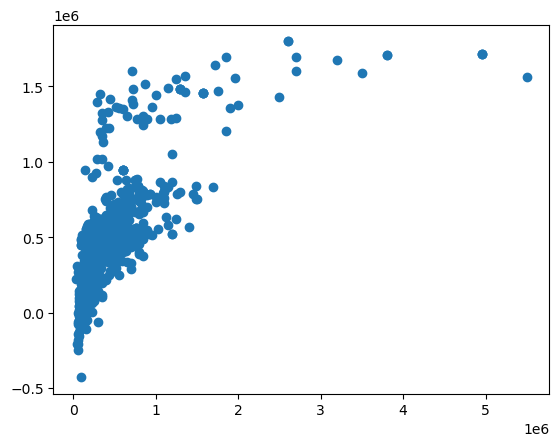

In [75]:
# Compare predicted values to the true values
# Ideally, there would be a straight line x=y
plt.scatter(y_val, y_val_pred)
plt.show()

## Conclusion

## References